# ACME Happiness Survey 2020

## Summary Notes
- There's not much data here, and 59 columns looked like bad data (I need to make sure that did not happen during the download)
- once data was cleaned the top columns seem to be order_delivered (X1), courier (X5), price (X4)
- Just removing coloums that had high correlation (e.g. app (X6) and order_delivered (X1) )  did not seem to work right away - perhaps with more effort...
- PCA analysis seemed to work better for feature reduction, but I'm not sure that it really reduced the data by much.
- Pycaret chose LogisticRegression as the best model
- The PCA dataset and LogisticRegression yeiled the best score I could get (71%)

---

<a id='toc'></a>
## Table of Contents

* [Read and Review](#review)
* [Clean Data](#cleanup)
* [Features Heatmap](#heatmap)
* [Correlation to Happy](#correlation)
* [Feature Gain](#gain)
* [Principal Component Analysis](#pca)
* [Logistic Regression](#accuracy)

In [18]:
from ultimate_utils import plot_heatmap
from ultimate_utils import correlate_to_target, plot_correlations
from ultimate_utils import calc_feature_importance

import pandas as pd
import warnings

warnings.filterwarnings("ignore")


# Read and Review data <a id='review'></a>

Change column names to something I can remember

| Original name | New name                                        | Description                                                                     : |
|---------------|-------------------------------------------------|-----------------------------------------------------------------------------------|
| Y             | <span style="color:teal">happy</span>           | target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers   |
| X1            | <span style="color:teal">order_delivered</span> | my order was delivered on time                                                    |
| X2            | <span style="color:teal">order_correct</span>   | contents of my order was as I expected                                            |
| X3            | <span style="color:teal">menu_complete</span>   | I ordered everything I wanted to order                                            |
| X4            | <span style="color:teal">price</span>           | I paid a good price for my order                                                  |
| X5            | <span style="color:teal">courier</span>         | I am satisfied with my courier                                                    |
| X6            | <span style="color:teal">app</span>             | the app makes ordering easy for me                                                |


In [2]:
df = pd.read_csv('ACME-HappinessSurvey2020.csv', header=0, names=[
                     'happy', 
                     'order_delivered',
                     'order_correct',
                     'menu_complete',
                     'price',
                     'courier',
                     'app'
                 ])

In [3]:
df.shape

(126, 7)

In [4]:
df.dtypes

happy              object
order_delivered    object
order_correct      object
menu_complete      object
price              object
courier            object
app                object
dtype: object

In [5]:
df.order_delivered.value_counts()

 in    59
5      38
4      19
3      10
Name: order_delivered, dtype: int64

# Cleanup <a id='cleanup'></a>
### Remove rows with non-numeric values 


In [6]:

df = df.loc[df['happy'].isin(['0','1'])]

In [7]:
for col in df.columns:
    print("\n============\n", col)
    print(df[col].value_counts())


 happy
0    34
1    33
Name: happy, dtype: int64

 order_delivered
5    38
4    19
3    10
Name: order_delivered, dtype: int64

 order_correct
3    23
2    15
4    13
1    11
5     5
Name: order_correct, dtype: int64

 menu_complete
3    30
4    15
5    11
2     9
1     2
Name: menu_complete, dtype: int64

 price
4    35
3    15
5    13
2     3
1     1
Name: price, dtype: int64

 courier
4    22
5    20
3    12
2     8
1     5
Name: courier, dtype: int64

 app
5    33
4    21
3    11
2     1
1     1
Name: app, dtype: int64


### Convert object types to int

In [8]:
df = df.astype(int)

In [9]:
df.dtypes

happy              int64
order_delivered    int64
order_correct      int64
menu_complete      int64
price              int64
courier            int64
app                int64
dtype: object

## Feature Correlations  <a id='heatmap'></a>

- order_delivered, courier, and price correlate to happy
- app correlates to order_delivered and inversely to order_correct to some extent
- 

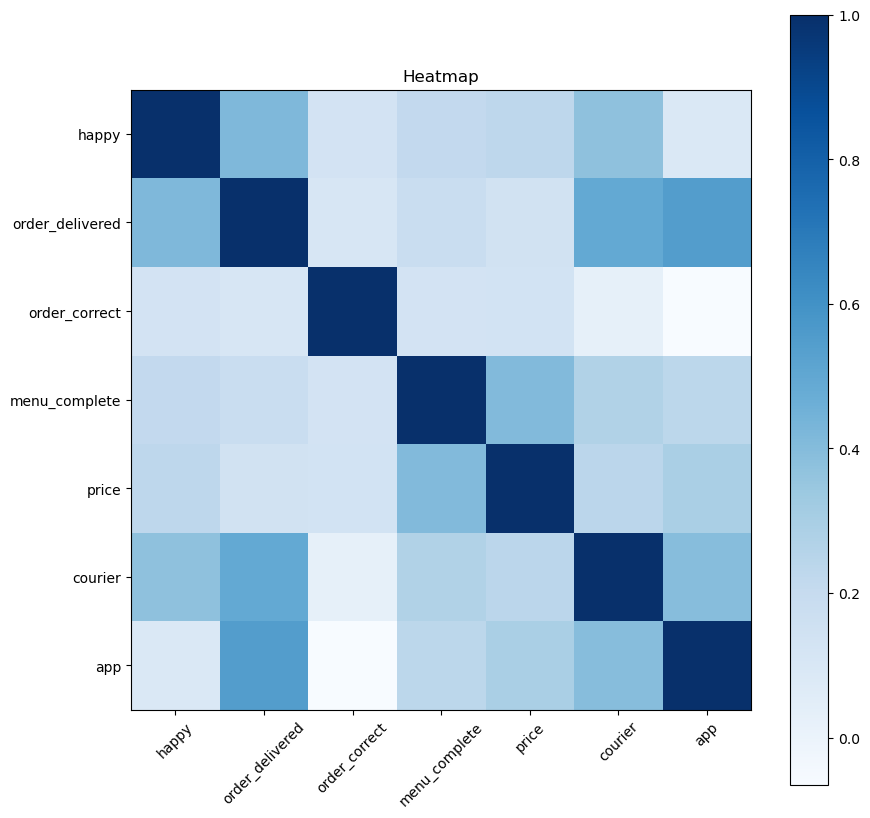

In [10]:
plot_heatmap(df, cmap='Blues', label_fontsize=10, method='pearson')

# Feature Selection   <a id='correlation'></a>

## Kendall Correlation to target
Which features correlate best to the happy target?

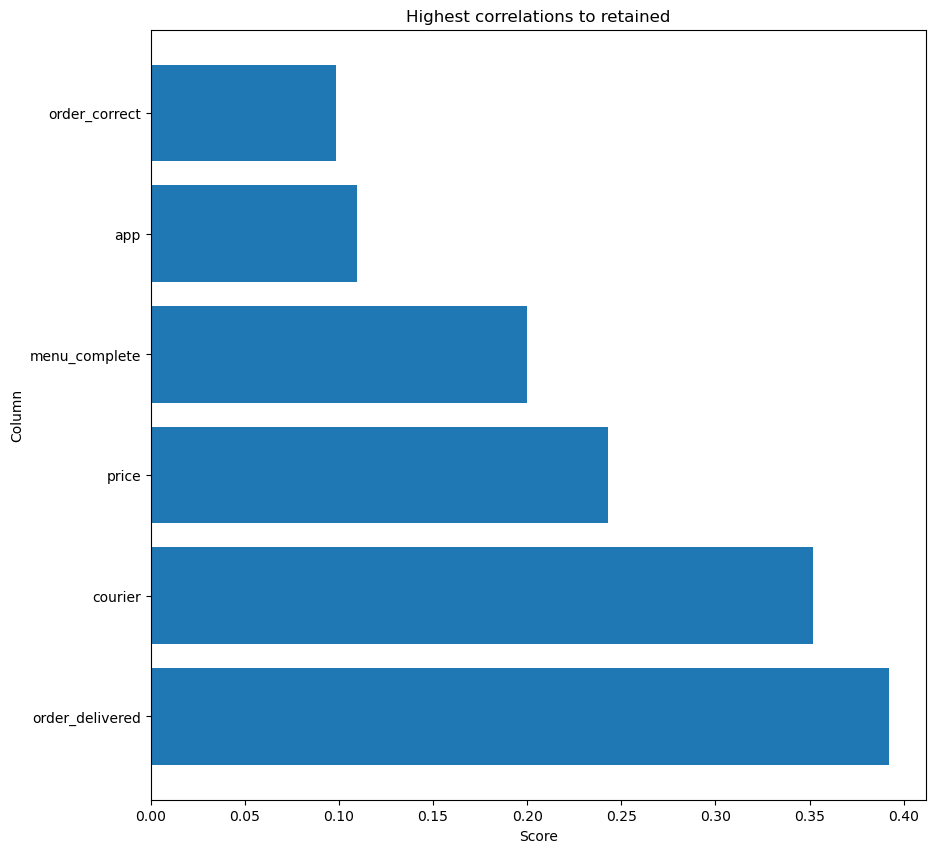

In [11]:
top_correlations, set_correlations = correlate_to_target(df, 'happy', 30, method='kendall')
plot_correlations(top_correlations['corr'], top_correlations['y'], 'Highest correlations to retained')

# Calculated Gain -- xgboost  <a id='gain'></a>

Which features does xgboost think important?

In [12]:
X = df.copy()
y = X.pop('happy')

top_features, set_features = calc_feature_importance(X, y, top_n=30)

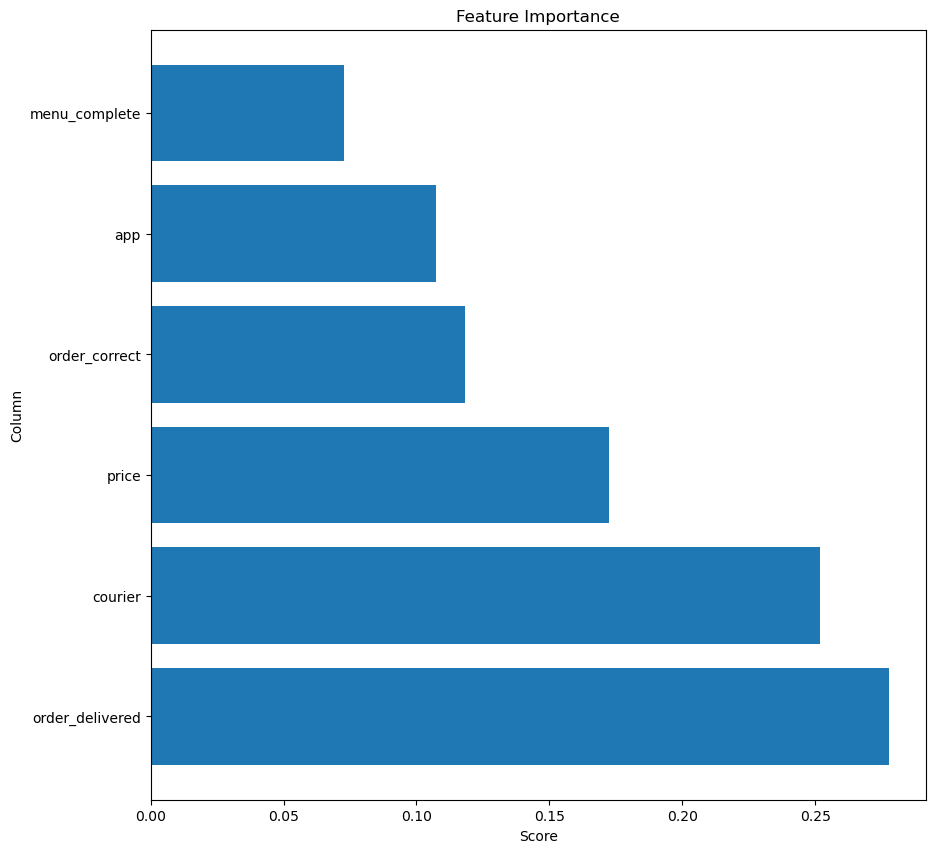

In [13]:
plot_correlations(
    top_features['corr'],
    top_features['y'], "Feature Importance")

## PCA Analysis  <a id='pca'></a>
Can we reduce dimensionality and increase accuracy with PCA analysis

In [14]:
features = df[['order_delivered', 'order_correct', 'menu_complete', 'price',
       'courier', 'app']]

target = df['happy']


# y = target.values.ravel()
# y.shape

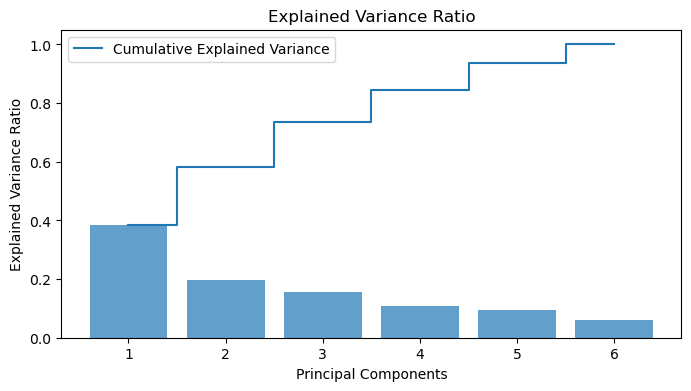

Number of Components Selected: 6
        PC1       PC2       PC3       PC4       PC5       PC6
0  1.760383  1.025282 -0.656312 -0.776967 -0.028640  0.790528
1  1.178199  1.088646 -1.534793  0.211618  1.826163  0.040886
2 -0.051123 -0.926954  0.818238 -0.484525 -0.995532  0.119880
3 -0.136077 -0.422905  1.485066 -0.582657 -0.999506  0.311168
4 -0.136077 -0.422905  1.485066 -0.582657 -0.999506  0.311168
Loadings:
                      PC1       PC2       PC3       PC4       PC5       PC6
order_delivered -0.483497 -0.329388  0.374450 -0.057015 -0.209911 -0.685717
order_correct   -0.097954  0.581182  0.768871 -0.113148 -0.004582  0.220561
menu_complete   -0.379684  0.454462 -0.322829  0.492596 -0.549940  0.000513
price           -0.375562  0.464631 -0.385653 -0.457219  0.459847 -0.271725
courier         -0.476989 -0.200563  0.100500  0.547802  0.595503  0.259703
app             -0.493872 -0.301807 -0.074690 -0.481829 -0.295634  0.582979


In [15]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Sample data
np.random.seed(0)
data = np.random.rand(100, 5)  # 100 samples with 5 features




# Standardize the data (PCA is sensitive to scale)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Determine the number of components to retain (e.g., 95% of variance)
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

# Apply PCA with the selected number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)

# Access the loadings (contributions of original features to principal components)
loadings = pca.components_

# Create a DataFrame of the principal components with feature names
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components + 1)])

# Create a DataFrame of loadings with feature names
loadings_df = pd.DataFrame(data=loadings.T, columns=[f'PC{i}' for i in range(1, n_components + 1)], index=features.columns)

# Plot explained variance ratio
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.title('Explained Variance Ratio')
plt.show()

# Print the number of components selected, the DataFrame of principal components, and the loadings
print(f'Number of Components Selected: {n_components}')
print(principal_df.head())
print("Loadings:")
print(loadings_df)


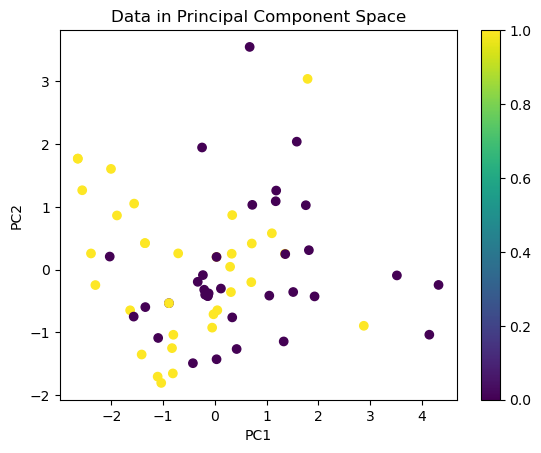

In [16]:
import matplotlib.pyplot as plt

plt.scatter(principal_df['PC1'], principal_df['PC2'], c=y, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data in Principal Component Space')
plt.colorbar()
plt.show()


## Accuracy  <a id='accuracy'></a>

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(principal_df, y, test_size=0.2, random_state=42)

# Fit a model using the principal components as features
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model on the test set
accuracy = model.score(X_test, y_test)

print(accuracy)

0.7142857142857143
